# 라이브러리 임포트

In [1]:
import numpy as np
from skimage import img_as_float, exposure, img_as_ubyte
from skimage.color import rgb2gray
from skimage.io import imread
from skimage.restoration import denoise_bilateral, denoise_nl_means, \
								  estimate_sigma
from skimage.measure import compare_psnr
from skimage.util import random_noise
from PIL import Image, ImageEnhance, ImageFilter
from scipy import ndimage
import matplotlib.pylab as pylab

# 로그 변환 - 색상 채널 히스토그램

In [2]:
# 영상 표시 함수
def plot_image(image, title=''):
    pylab.title(title, size=20), pylab.imshow(image)
    pylab.axis('off') # 그래프에 축 보이기 원한다면 이 라인 주석처리
    
# 히스토그램 그리기 함수
def plot_hist(r, g, b, title=''):
    r, g, b = img_as_ubyte(r), img_as_ubyte(g), img_as_ubyte(b)    
    r, g, b = np.array(r).ravel(), np.array(g).ravel(), np.array(b).ravel()    
    pylab.hist(r, bins=256, range=(0, 256), color='r', alpha=0.5)
    pylab.hist(g, bins=256, range=(0, 256), color='g', alpha=0.5)
    pylab.hist(b, bins=256, range=(0, 256), color='b', alpha=0.5)
    pylab.xlabel('pixel value', size=20)
    pylab.ylabel('frequency',size=20), pylab.title(title, size=20)

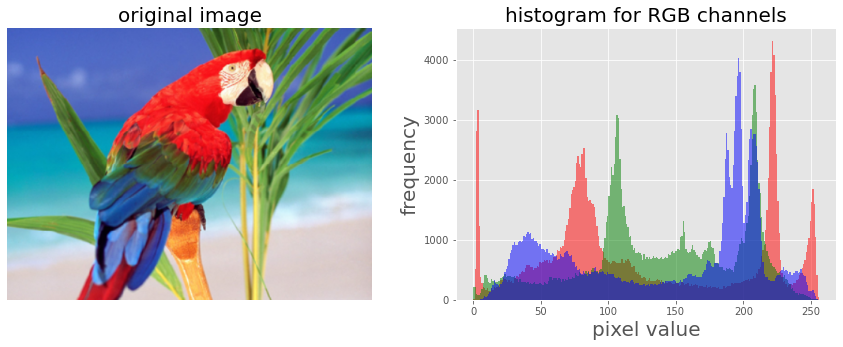

In [28]:
im = Image.open("../images/parrot.png")
im_r, im_g, im_b = im.split()
pylab.style.use('ggplot')
pylab.figure(figsize=(15,5))
pylab.subplot(121), plot_image(im, 'original image')
pylab.subplot(122)
plot_hist(im_r, im_g, im_b,'histogram for RGB channels')
pylab.show()

# 로그 변환 적용, 색상 히스토그램

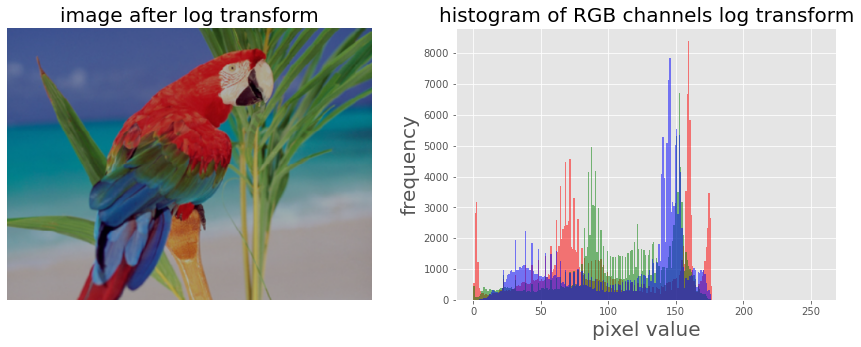

In [29]:
im = im.point(lambda i: 255*np.log(1+i/255))
im_r, im_g, im_b = im.split()

pylab.style.use('ggplot')
pylab.figure(figsize=(15,5))
pylab.subplot(121), plot_image(im, 'image after log transform')
pylab.subplot(122)
plot_hist(im_r, im_g, im_b, 'histogram of RGB channels log transform')
pylab.show()

# 파워-로우 변환

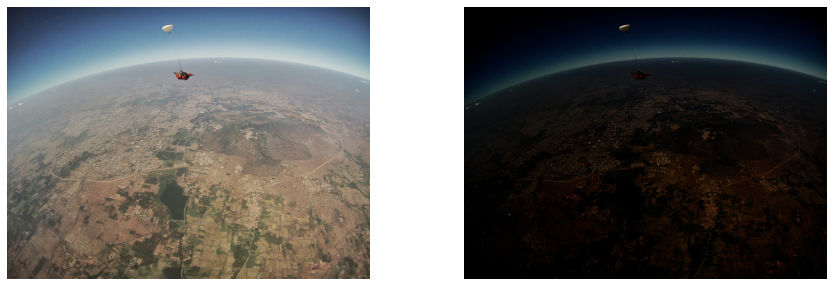

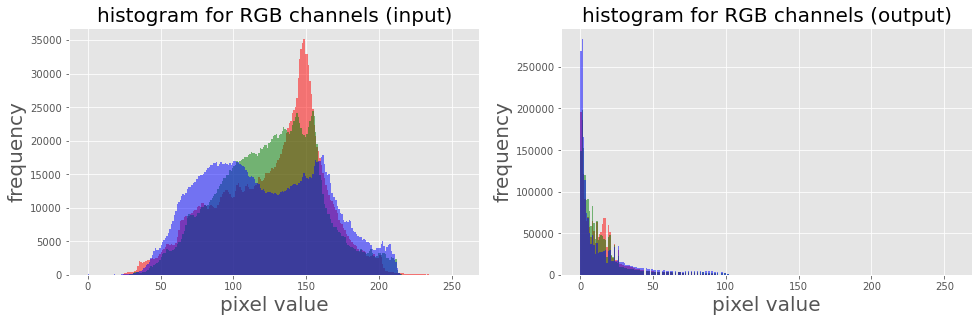

In [27]:
im = img_as_float(imread('../images/earthfromsky.jpg'))
gamma = 5
im1 = im**gamma

pylab.figure(figsize=(15,5))
pylab.subplot(121), plot_image(im)
pylab.subplot(122), plot_image(im1)
pylab.figure(figsize=(25,10)), pylab.style.use('ggplot')
pylab.subplot(231)
plot_hist(im[...,0], im[...,1], im[...,2], 'histogram for RGB channels (input)')
pylab.subplot(232)
plot_hist(im1[...,0], im1[...,1], im1[...,2], 'histogram for RGB channels (output)')
pylab.show()

# 점 연산으로 PIL 사용

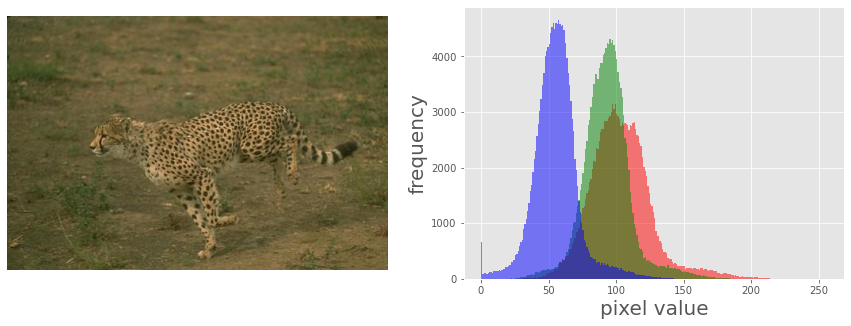

In [30]:
im = Image.open('../images/cheetah.png')
im_r, im_g, im_b, _ = im.split()

pylab.style.use('ggplot')
pylab.figure(figsize=(15,5))
pylab.subplot(121), plot_image(im)
pylab.subplot(122), plot_hist(im_r, im_g, im_b)
pylab.show()

# 콘트라스트 스트레칭 구현

PIL.point() 함수를 사용하여 콘트라스트 스트레칭을 구현한다.

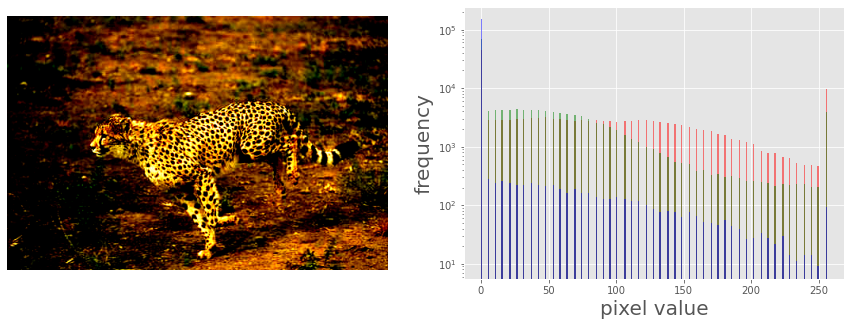

In [31]:
def contrast(c):
    return 0 if c < 70 else (255 if c > 150 else (255*c - 22950) / 48)

im1 = im.point(contrast)
im_r, im_g, im_b, _ = im1.split()

pylab.style.use('ggplot')
pylab.figure(figsize=(15,5))
pylab.subplot(121), plot_image(im1)
pylab.subplot(122), plot_hist(im_r, im_g, im_b)
pylab.yscale('log',basey=10)
pylab.show()

# PIL ImageEnhance 모듈 사용

ImageEnhance 모듈은 콘트라스트 스트레칭에도 사용할 수 있다.

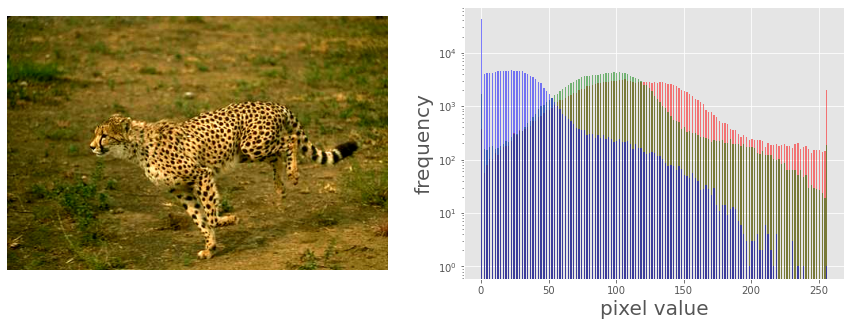

In [32]:
contrast = ImageEnhance.Contrast(im)
contrast = np.array(contrast.enhance(2).getdata()).astype(np.uint8)
im1 = np.reshape(contrast,(im.height, im.width, 4))

pylab.style.use('ggplot')
pylab.figure(figsize=(15,5))
pylab.subplot(121), plot_image(im1)
pylab.subplot(122), plot_hist(im1[...,0], im1[...,1], im1[...,2])
pylab.yscale('log',basey=10)
pylab.show()

# 고정된 임계치

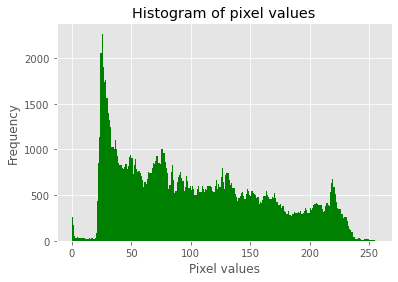

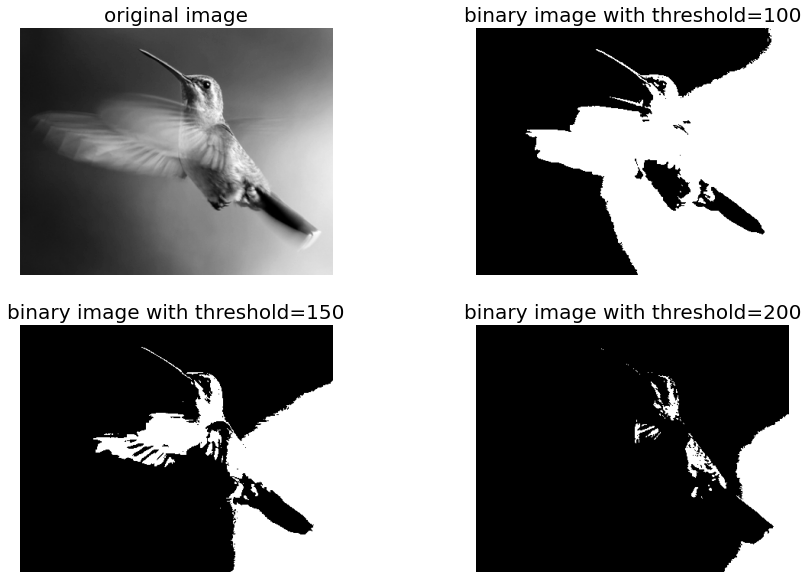

In [39]:
im = Image.open('../images/bird.png').convert('L')

pylab.hist(np.array(im).ravel(), bins=256, range=(0, 256), color='g')
pylab.xlabel('Pixel values'), pylab.ylabel('Frequency')
pylab.title('Histogram of pixel values')
pylab.show()

pylab.figure(figsize=(15,10))
pylab.subplot(221), plot_image(im, 'original image'), pylab.axis('off')
pylab.gray()

for i, th, in enumerate([100, 150, 200]):
    im1 = im.point(lambda x: x > th)
    pylab.subplot(2,2,i+2),
    plot_image(im1, 'binary image with threshold=' + str(th))
pylab.show()

# 하프-토닝

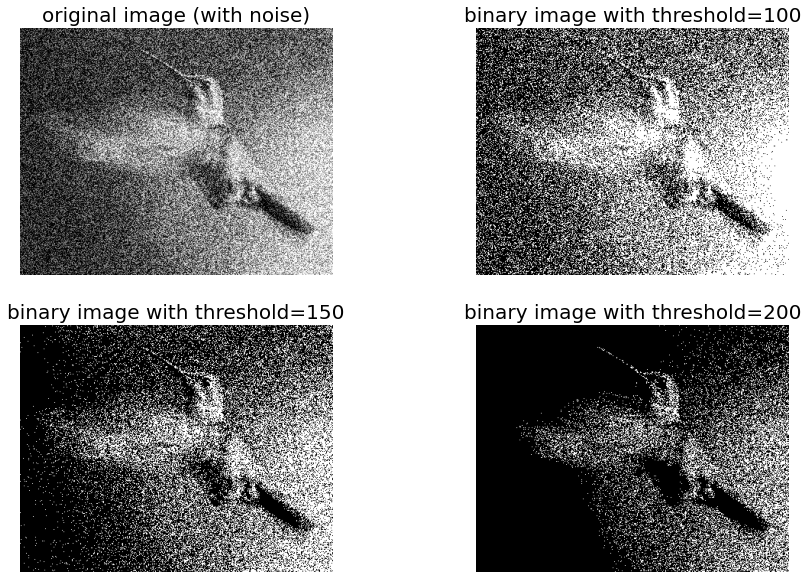

In [41]:
im = Image.open('../images/bird.png').convert('L')
im += np.random.randint(-128, 128, (im.height, im.width))
im = Image.fromarray(np.clip(im, 0, 255).astype(np.uint8))

pylab.figure(figsize=(15,10))
pylab.subplot(221), plot_image(im, 'original image (with noise)')
pylab.gray()

for i, th, in enumerate([100, 150, 200]):
    im1 = im.point(lambda x: x > th)
    pylab.subplot(2,2,i+2)
    plot_image(im1, 'binary image with threshold=' + str(th))
pylab.show()

# Scikit-image를 이용한 콘트라스트 스트레칭과 히스토그램 평활화

<Figure size 432x288 with 0 Axes>

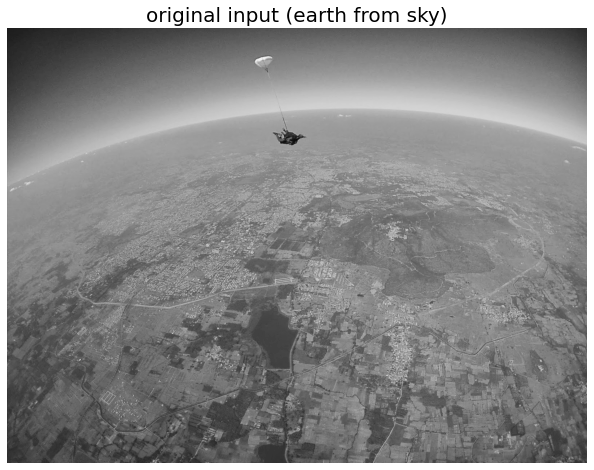

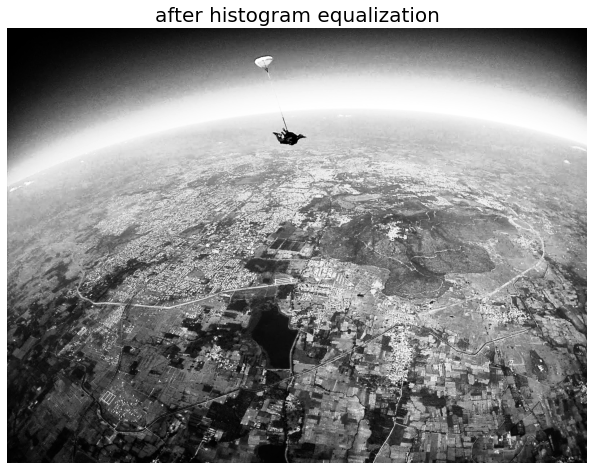

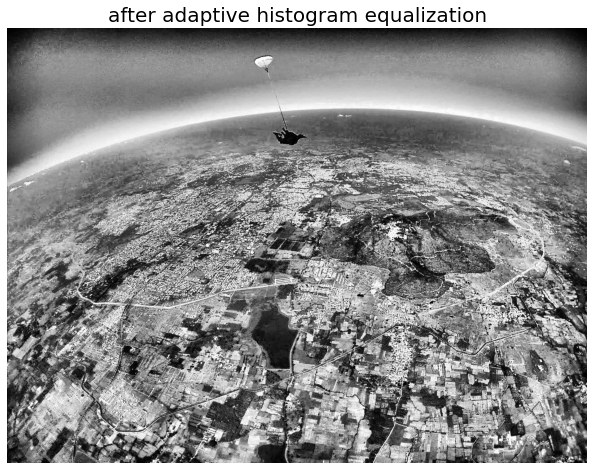

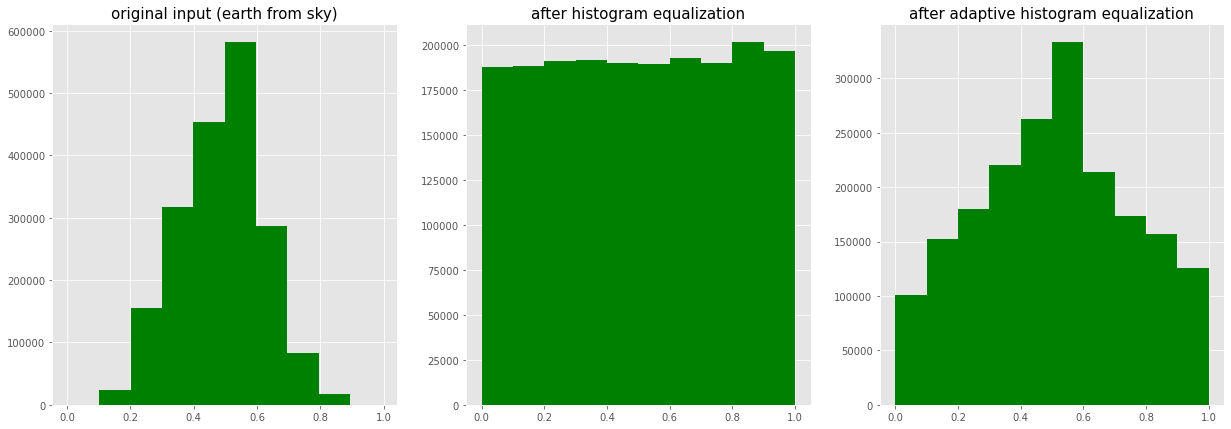

In [42]:
img = rgb2gray(imread('../images/earthfromsky.jpg'))
img_eq = exposure.equalize_hist(img)  			 			# 전역 히스토그램 평활화
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03) # 지역적 평활화
images = [img, img_eq, img_adapteq]  			 			# 영상 리스트

titles = ['original input (earth from sky)', \
          'after histogram equalization', \
          'after adaptive histogram equalization']  			# 그래프 영상 타이틀

pylab.gray()
for i in range(3):
    pylab.figure(figsize=(12,8)), plot_image(images[i], titles[i])

pylab.figure(figsize=(21,7))
for i in range(3):
    pylab.subplot(1,3,i+1), pylab.title(titles[i], size=15)
    pylab.hist(images[i].ravel(), color='g')
pylab.show()

# 히스토그램 처리 기술로 영상 향상

C:\Users\sinsm\anaconda3\lib\site-packages\skimage\exposure\exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
C:\Users\sinsm\anaconda3\lib\site-packages\skimage\exposure\exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
C:\Users\sinsm\anaconda3\lib\site-packages\skimage\exposure\exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
C:\Users\sinsm\anaconda3\lib\site-packages\skimage\exposure\exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flatte

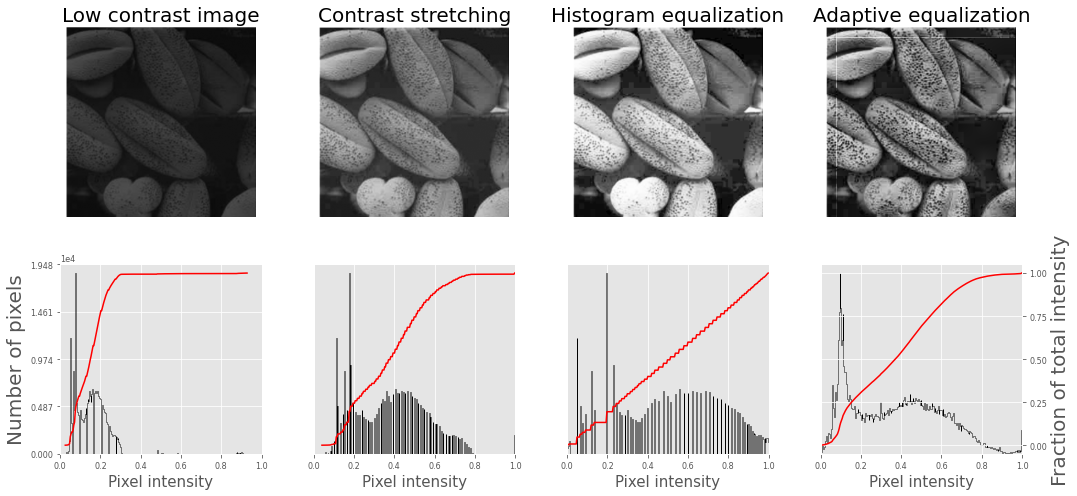

In [44]:
import matplotlib
def plot_image_and_hist(image, axes, bins=256):
    image = img_as_float(image)
    axes_image, axes_hist = axes
    axes_cdf = axes_hist.twinx()    
    axes_image.imshow(image, cmap=pylab.cm.gray)
    axes_image.set_axis_off()
    
    axes_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    axes_hist.set_xlim(0, 1)
    axes_hist.set_xlabel('Pixel intensity', size=15)
    axes_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    axes_hist.set_yticks([])

    image_cdf, bins = exposure.cumulative_distribution(image, bins)
    axes_cdf.plot(bins, image_cdf, 'r')
    axes_cdf.set_yticks([])
    return axes_image, axes_hist, axes_cdf

im = imread('../images/beans_g.png')
im_rescale = exposure.rescale_intensity(im, in_range=(2, 98)) # 대조 스트레칭
im_eq = exposure.equalize_hist(im) # 히스토그램 평활화
im_adapteq = exposure.equalize_adapthist(im, clip_limit=0.03)# 적응적 평활화

matplotlib.rcParams['font.size'] = 8
fig = pylab.figure(figsize=(15, 7))
axes = np.zeros((2, 4), dtype = np.object)

for i in range(0, 4):
    axes[0, i] = fig.add_subplot(2, 4, i+1)
    axes[1, i] = fig.add_subplot(2, 4, i+5)
    
axes_image, axes_hist, axes_cdf = plot_image_and_hist(im, axes[:, 0])
axes_image.set_title('Low contrast image', size=20)
y_min, y_max = axes_hist.get_ylim()
axes_hist.set_ylabel('Number of pixels', size=20)
axes_hist.set_yticks(np.linspace(0, y_max, 5))

axes_image, axes_hist, axes_cdf = plot_image_and_hist(im_rescale, axes[:,1])
axes_image.set_title('Contrast stretching', size=20)
axes_image, axes_hist, axes_cdf = plot_image_and_hist(im_eq, axes[:, 2])
axes_image.set_title('Histogram equalization', size=20)
axes_image, axes_hist, axes_cdf = plot_image_and_hist(im_adapteq, axes[:,3])
axes_image.set_title('Adaptive equalization', size=20)
axes_cdf.set_ylabel('Fraction of total intensity', size=20)

axes_cdf.set_yticks(np.linspace(0, 1, 5))
fig.tight_layout()
pylab.show()

# 히스토그램 매칭

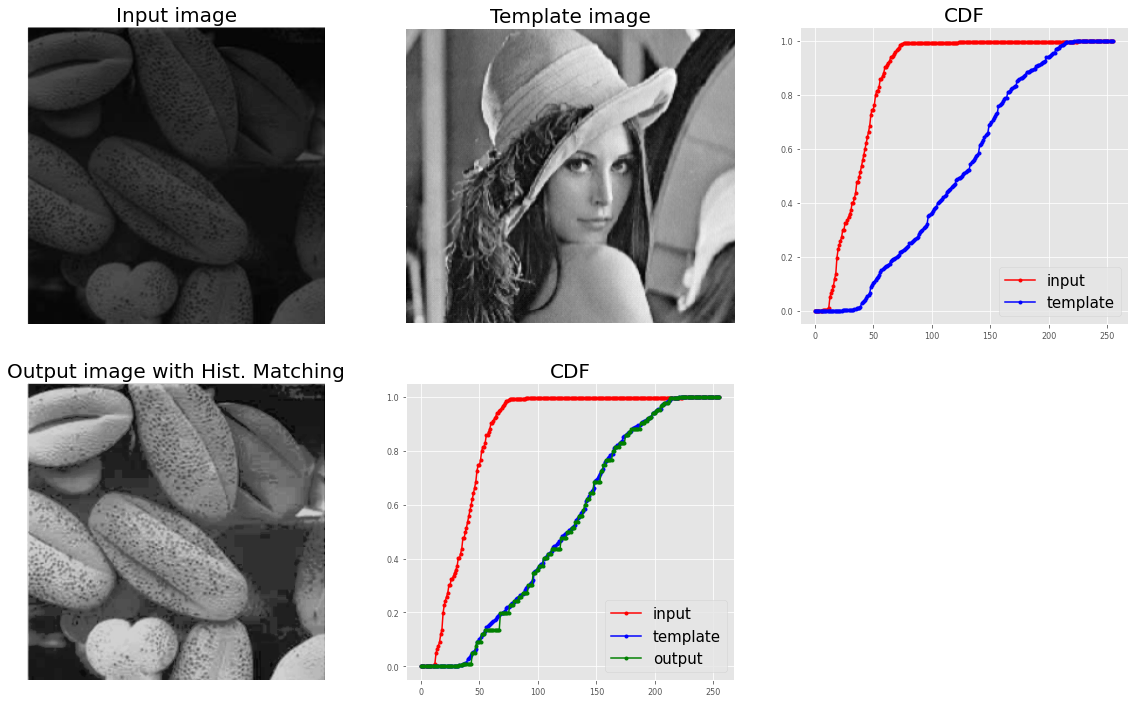

In [45]:
def cdf(im):
    ''' 2D ndarray로서 im 영상의 CDF 계산 '''
    c, b = exposure.cumulative_distribution(im)
    c = np.insert(c, 0, [0]*b[0])
    
    c = np.append(c, [1]*(255-b[-1]))
    return c

def hist_matching(c, c_t, im):
    '''
    c: cdf() 함수로 계산된 입력 영상의 CDF
    c_t: cdf() 함수로 계산된 템플릿 영상의 CDF
    im: 2D numpy ndarray로서 입력 영상
    반환 값은 입력 영상에 대해 수정된 화소 값들
    '''
    # 탬플릿 영상의 CDF H 값이 주어지면, 입력 영상의 CDF에 상응하는
    # 가장 가까운 화소 매칭 검색 c_t = H(pixels) <=> pixels = H-1(c_t)
    pixels = np.arange(256)
    new_pixels = np.interp(c, c_t, pixels)
    im = (np.reshape(new_pixels[im.ravel()], im.shape)).astype(np.uint8)
    return im

im = (rgb2gray(imread('../images/beans_g.png'))*255).astype(np.uint8)
im_t = (rgb2gray(imread('../images/lena_g.png'))*255).astype(np.uint8)
c, c_t = cdf(im), cdf(im_t)

im1 = hist_matching(c, c_t, im)
c1 = cdf(im1)

p = np.arange(256)
pylab.figure(figsize=(20,12)), pylab.gray()
pylab.subplot(2,3,1), plot_image(im, 'Input image')
pylab.subplot(2,3,2), plot_image(im_t, 'Template image')
pylab.subplot(2,3,3)
pylab.plot(p, c, 'r.-', label='input')
pylab.plot(p, c_t, 'b.-', label='template')
pylab.legend(prop={'size': 15}), pylab.title('CDF', size=20)

pylab.subplot(2,3,4)
plot_image(im1, 'Output image with Hist. Matching')
pylab.subplot(2,3,5)
pylab.plot(p, c, 'r.-', label='input')
pylab.plot(p, c_t, 'b.-', label='template')
pylab.plot(p, c1, 'g.-', label='output')
pylab.legend(prop={'size': 15}), pylab.title('CDF', size=20)
pylab.show()